In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import random
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20
import category_encoders as ce

Create columns name for dataset

In [2]:
col_name = ["fLength", "fWidth", "fSize", "fConc", "fConc1", 
            "fAsym", "fM3Long", "fM3Trans","fAlpha", "fDist","class"]

Open dataset from drive

In [3]:
magic_dt = pd.read_csv("/Users/Morgan/Documents/316/magic04.data", names =  col_name)

Inspect dataset

In [4]:
magic_dt.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


check unique values in the class columns of the dataset

In [5]:
magic_dt['class'].value_counts()

g    12332
h     6688
Name: class, dtype: int64

encode the targeted class columns 'g': 1.0, 'h' : 2.0

In [6]:
encoder= ce.OrdinalEncoder(cols=['class'],return_df=True,
                           mapping=[{'col':'class',
'mapping':{ None: 0, 'g': 1.0, 'h' : 2.0}}])

In [7]:
magic_dt_transformed = encoder.fit_transform(magic_dt)

Inspect dataset after ordinal encoding

In [8]:
magic_dt_transformed.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


Create two parts of the dataset, seperate the targeted class columns from the rest of the dataset, x is the rest of the dataset, while y is the class column

In [9]:
x = magic_dt_transformed.drop('class', axis=1)
y = magic_dt_transformed['class']

Split x and y into training and test set

In [10]:
#Function to spilt dataset into training set and test set
def train_test_split(dt, test_size):
    if isinstance(test_size, float):
     test_size = round(test_size * len(dt))
    
    indices = dt.index.tolist()
    test_indices = random.sample(population = indices, k = test_size)

    test_df = dt.loc[test_indices]
    train_df = dt.drop(test_indices)


    return train_df, test_df  

In [11]:
x_train, x_test = train_test_split(x, test_size = 0.3)

Inspect shape of training and test set

In [12]:
print(x_train.shape, x_test.shape)

(13314, 10) (5706, 10)


In [13]:
y_train, y_test = train_test_split(y, test_size = 0.3)

In [14]:
print(y_train.shape, y_test.shape)

(13314,) (5706,)


Standardize features in dataset by removing the mean and scaling to unit variance.

In [15]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Create ANN by using tensorflow keras, there are a total of 5 layers( 3 hidden layers ), 
the first 4 layers have a total of 1000 units, 
while the last layer have 1 units. There are total of 50 epochs, the total batchsize is 1000

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras import regularizers
from keras.layers import Dropout

model = Sequential()
model.add(Dense(units = 1000, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l2(0.02), 
                input_shape=(10,)))
model.add(Dropout(0.4))
model.add(Dense(units = 1000, kernel_initializer = 'uniform', activation = 'relu', 
                kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.4))
model.add(Dense(units = 1000, kernel_initializer = 'uniform', activation = 'relu', 
                kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.4))
model.add(Dense(units = 1000, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.4))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.02)))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(10, activation='softmax'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#model.fit(x_train, y_train, batch_size = 100, epochs = 50, verbose=1)
#create model summary
model.summary()
history =  model.fit(x_train, y_train, batch_size = 1000, epochs = 50, verbose=1,   validation_data=(x_test, y_test))
#print(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              11000     
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              1001000   
                                                                 
 dropout_2 (Dropout)         (None, 1000)              0         
                                                                 
 dense_3 (Dense)             (None, 1000)              1

14/14 [==============================] - 1s 82ms/step - loss: -4724086538240.0000 - accuracy: 0.6486 - val_loss: -3485876355072.0000 - val_accuracy: 0.6479
Epoch 42/50
14/14 [==============================] - 1s 75ms/step - loss: -5410247933952.0000 - accuracy: 0.6486 - val_loss: -3972764532736.0000 - val_accuracy: 0.6479
Epoch 43/50
14/14 [==============================] - 1s 80ms/step - loss: -6167589814272.0000 - accuracy: 0.6486 - val_loss: -4515172974592.0000 - val_accuracy: 0.6479
Epoch 44/50
14/14 [==============================] - 1s 87ms/step - loss: -6988647890944.0000 - accuracy: 0.6486 - val_loss: -5108885618688.0000 - val_accuracy: 0.6479
Epoch 45/50
14/14 [==============================] - 1s 89ms/step - loss: -7883631624192.0000 - accuracy: 0.6486 - val_loss: -5768682143744.0000 - val_accuracy: 0.6479
Epoch 46/50
14/14 [==============================] - 1s 87ms/step - loss: -8892523216896.0000 - accuracy: 0.6486 - val_loss: -6488354979840.0000 - val_accuracy: 0.6479
Epoc

Create history table of all the 50 epoch

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head(50)

,loss,accuracy,val_loss,val_accuracy,epoch
0,3.156048e+01,0.629187,-1.324339e+01,0.647914,0
1,-8.994554e+02,0.648565,-3.535983e+03,0.647914,1
2,-2.551222e+04,0.648565,-6.437554e+04,0.647914,2
3,-2.922032e+05,0.648565,-5.423839e+05,0.647914,3
4,-1.870443e+06,0.648565,-2.900769e+06,0.647914,4
5,-8.345736e+06,0.648565,-1.141216e+07,0.647914,5
6,-2.916233e+07,0.648565,-3.606367e+07,0.647914,6
7,-8.471248e+07,0.648565,-9.697794e+07,0.647914,7
8,-2.153768e+08,0.648565,-2.297912e+08,0.647914,8
9,-4.818739e+08,0.648565,-4.919660e+08,0.647914,9


Test predict of neural network using test and train set

In [21]:
model.predict(x_train)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [22]:
model.predict(x_test)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

plot entropy curve comparing training and test set 

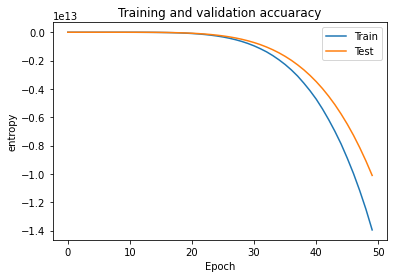

In [28]:
from matplotlib import pyplot as plt 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation accuaracy')
plt.ylabel('entropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Evaluate accuracy of neural network using training and testing set
In this case the accuracy of training set is 0.6486 and testing testing set is 0.6479


In [29]:
model.evaluate(x_train,  y_train, verbose=2)

417/417 - 2s - loss: -1.4773e+13 - accuracy: 0.6486 - 2s/epoch - 4ms/step


[-14773468004352.0, 0.648565411567688]

In [30]:
model.evaluate(x_test,  y_test, verbose=2)

179/179 - 1s - loss: -1.0103e+13 - accuracy: 0.6479 - 809ms/epoch - 5ms/step


[-10102778101760.0, 0.647914469242096]